In [30]:
import json
import pickle
import math
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
from pathlib import Path
import matplotlib.pyplot as plt
from argparse import Namespace

import tensorflow as tf

from flowers_utils import *

AUTO = tf.data.experimental.AUTOTUNE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## questions

So what questions do I have?
- where do I shuffle my data; 
    - **when reading**: we read files with `filenames = tf.io.gfile.glob(self.GCS_PATTERN)` which does not randomize our files in comparison with `list_files` (*The default behavior of this method is to return filenames in a non-deterministic random shuffled order.*); but we use `num_parallel_reads=AUTO` (**not** `num_parallel_calls=AUTO`) and in *Geron* we may read that: *By default, a `TFRecordDataset` will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting* this option. (*A tf.int64 scalar representing the number of files to read in parallel. If greater than one, the records of files read in parallel are outputted in an interleaved order.*)
- how do we prepare for training on ImageNet;
- what operations on the datasets do I perform?
- should I cache my data in this case?

What should I do to finish this data preparation classes:
- check shuffling;
- add interleaving;
- correct batch size;

## read TFRecord file: DEBUG

In [31]:
fds = FlowerDataSet()

### 1 - read tfrecord

In [32]:
filenames = tf.io.gfile.glob(fds.GCS_PATTERN)

In [8]:
len(filenames)

16

In [7]:
filenames[:3]

['gs://dl-projects-2020-bucket-1/flowers/tfrecords-jpeg-192x192/flowers00-230.tfrec',
 'gs://dl-projects-2020-bucket-1/flowers/tfrecords-jpeg-192x192/flowers01-230.tfrec',
 'gs://dl-projects-2020-bucket-1/flowers/tfrecords-jpeg-192x192/flowers02-230.tfrec']

In [33]:
dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)

In [19]:
# somehow this dataset knows that we have 3670 images
dataset, len(list(dataset))

(<TFRecordDatasetV2 shapes: (), types: tf.string>, 3670)

In [21]:
# so this is probably a byte string for one image
for example in dataset.take(1):
    print(type(example.numpy()), len(example.numpy()), example.numpy()[:10])

<class 'bytes'> 33049 b'\n\x95\x82\x02\n\x0e\n\x05cl'


Can we read this byte string manually?

In [29]:
FlowerTFRecordReader.FEATURES

{'image': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'class': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}

In [43]:
# so we split a byte string into image and class number
# but image is still a byte string (shorter than before)
for example in dataset.take(1):
    parsed_example = tf.io.parse_single_example(example, FlowerTFRecordReader.FEATURES)
    print(type(parsed_example), parsed_example.keys())
    print(type(parsed_example['image'].numpy()), len(parsed_example['image'].numpy()), 
          parsed_example['image'].numpy()[:10])
    print(type(parsed_example['class'].numpy()), parsed_example['class'].numpy())

<class 'dict'> dict_keys(['class', 'image'])
<class 'bytes'> 33006 b'\xff\xd8\xff\xe0\x00\x10JFIF'
<class 'numpy.int64'> 4


In [49]:
for example in dataset.take(1):
    parsed_example = tf.io.parse_single_example(example, FlowerTFRecordReader.FEATURES)
    image = parsed_example['image']
    image = tf.image.decode_jpeg(image, channels=params.N_CHANNELS)
    print(type(image.numpy()), image.numpy().shape, 
          image.numpy().dtype, image.numpy()[0, 0, :])

<class 'numpy.ndarray'> (192, 192, 3) uint8 [215 223 225]


<class 'numpy.ndarray'> (192, 192, 3) uint8 [215 223 225]
float32 [215. 223. 225.]
float32 [0.6862745 0.7490196 0.7647059]


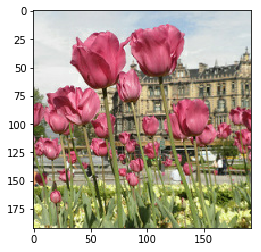

In [52]:
# finally let's preprocess this image
for example in dataset.take(1):
    parsed_example = tf.io.parse_single_example(example, FlowerTFRecordReader.FEATURES)
    image = parsed_example['image']
    image = tf.image.decode_jpeg(image, channels=params.N_CHANNELS)
    print(type(image.numpy()), image.numpy().shape, 
          image.numpy().dtype, image.numpy()[0, 0, :])
    image = tf.cast(image, tf.float32)
    print(image.numpy().dtype, image.numpy()[0, 0, :])
    image = tf.keras.applications.xception.preprocess_input(image)
    print(image.numpy().dtype, image.numpy()[0, 0, :])
    plt.imshow(image.numpy() / 2 + .5)

### 2 - check new implementation

In [53]:
ft = FlowerTrainer()

number of accelerators: 1


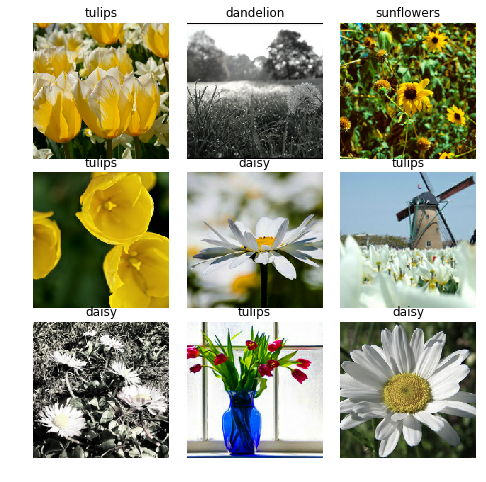

In [55]:
FlowerUtils.plot_sample_from_batch(ft.train_ds)

In [ ]:
ft.train()

Train for 93 steps, validate for 14 steps
Epoch 1/5
 1/93 [..............................] - ETA: 36:28 - loss: 1.6669 - accuracy: 0.1250